In [1]:
!pip install tensorflow_decision_forests opendatasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.8 MB/s eta 0:00:00


In [2]:
import tensorflow
import tensorflow_decision_forests as tfdf
import pandas as pd
import opendatasets as od
import seaborn as sns
import os

In [3]:
url = 'https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data'
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: harshitkatheria
Your Kaggle Key: ··········


100%|██████████| 199k/199k [00:00<00:00, 69.5MB/s]


Extracting archive ./house-prices-advanced-regression-techniques/house-prices-advanced-regression-techniques.zip to ./house-prices-advanced-regression-techniques


In [4]:
os.chdir('house-prices-advanced-regression-techniques')

In [5]:
train_data = pd.read_csv('train.csv')
train_data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [6]:
test_data = pd.read_csv('test.csv')
test_data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [7]:
#Dropping Id from train_data as it holds not value whatsoever
updated_train_data = train_data.drop('Id',axis=1)

In [8]:
updated_train_data.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [9]:
updated_train_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: ylabel='SalePrice'>

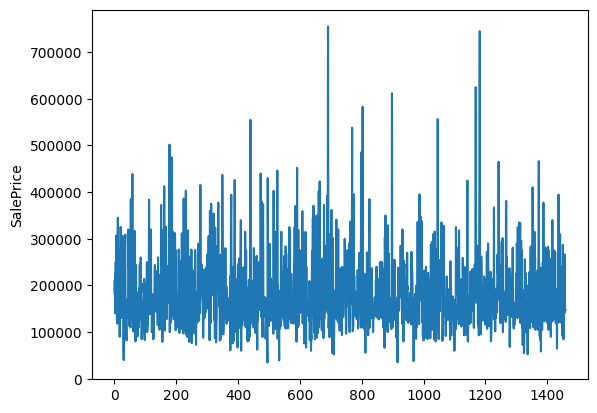

In [10]:
sns.lineplot(data = updated_train_data['SalePrice'])

In [11]:
# Dropping the columns that have more than 50% of null values
usable_cols = updated_train_data.columns[[x<=50 for x in (updated_train_data.isna().sum()*100/len(updated_train_data))]]

In [12]:
usable_cols

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

In [13]:
# Splitting the dataset
from sklearn.model_selection import train_test_split

def split_dataset(dataset, test_ratio=0.30):
    train_ds, val_ds = train_test_split(dataset, test_size=test_ratio)
    return train_ds, val_ds

# Convert the usable_cols to a DataFrame before splitting
usable_cols_df = updated_train_data[usable_cols]

train_ds_pd, val_ds_pd = split_dataset(usable_cols_df)

print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(val_ds_pd)))


1022 examples in training, 438 examples in testing.


In [14]:
# Converting the pandas df into tensorflow df
arget = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=target, task=tfdf.keras.Task.REGRESSION)
val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(val_ds_pd, label=target, task=tfdf.keras.Task.REGRESSION)


In [24]:
# model_gb = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION)
# model_gb.compile(metrics=['mse'])
model_rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_rf.compile(metrics=['mse'])

Use /tmp/tmp7yo2zxdn as temporary training directory


In [25]:
model_rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:00.902268. Found 1022 examples.
Training model...
Model trained in 0:00:02.913063
Compiling model...
Model compiled.


In [26]:
inspector = model_rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1022, accuracy=None, loss=None, rmse=28374.91491445789, ndcg=None, aucs=None, auuc=None, qini=None)

In [27]:
evaluation = model_rf.evaluate(x=val_ds,return_dict=True)
for name,value in evaluation.items():
  print(f'{name}: {value:.4f}')

1/1 [==============================] - 1s 592ms/step - loss: 0.0000e+00 - mse: 1044075328.0000
loss: 0.0000
mse: 1044075328.0000


In [19]:
ids = test_data.pop('Id')

In [28]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = model_rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 1s 29ms/step


,Id,SalePrice
0,1461,123752.445312
1,1462,154728.843750
2,1463,182312.859375
3,1464,185181.750000
4,1465,199876.218750


In [29]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_AS_ROOT
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES
	 SUM_SCORE


In [22]:
sample = pd.read_csv('sample_submission.csv')

In [31]:
sample['SalePrice'] = model_rf.predict(test_ds)
sample.to_csv('sub1.csv', index=False)
sample.head()

2/2 [==============================] - 1s 48ms/step


,Id,SalePrice
0,1461,123752.445312
1,1462,154728.843750
2,1463,182312.859375
3,1464,185181.750000
4,1465,199876.218750
